In [9]:
# Import libraries
%matplotlib inline
import pprint as pp
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

# Runge-Kutta 4th order solver
def RK4(f, t, y, dt, p):
    dy1 = dt*f(t, y, p)
    dy2 = dt*f(t + 0.5*dt, y + 0.5*dy1, p)
    dy3 = dt*f(t + 0.5*dt, y + 0.5*dy2, p)
    dy4 = dt*f(t + dt, y + dy3, p)
    return y + (dy1+2.*dy2+2.*dy3+dy4)/6.

# Solution to ordinary differential equations
def solve(prep, t1, t2, inicond, dt):
    def f(p):
        solution = inicond
        t, y = t1, inicond
        while t < t2-dt:
            t += dt
            y = RK4(prep, t, y, dt, p)
            solution = np.vstack((solution, y))
        return solution
    return f

# SINDy implementation
def eq_coef_list(alpha, theta, grads, symb_theta, no_at, cutoff):
    eq_list = [[] for i in range(len(grads[0]))]
    coef_list = []
    clf = Lasso(alpha = alpha)
    for eq_no in range(len(grads[0])):
        m = theta
        symb_m = symb_theta
        dv = grads
        for i in range(no_at):
            clf.fit(m, dv[:, eq_no])
            opt = np.abs(clf.coef_)
            aux = np.where(opt > cutoff)
            inds = aux[0].tolist()
            if True:
                m = m[:, inds]
                symb_m = itemgetter(*inds)(symb_m)
            else:
                m = m[:, inds]
                symb = np.array([])
        clf.fit(m, dv[:, eq_no])
        if (np.abs(clf.intercept_) > cutoff):
            coef_list.append(np.insert(clf.coef_, 0, clf.intercept_))
            eq_list[eq_no] += ['1']
        else:
            coef_list.append(clf.coef_)
        eq_list[eq_no] += list(symb_m)
    return [dict(zip(eq_list[i], coef_list[i])) for i in range(len(grads[0]))]

# Gradient determination
def grads(var):
    grads = np.zeros((len(var[0])-2, len(var)))
    for i in range(len(var)):
        grads[:, i] = (var[i][2:]-var[i][:-2])/(2*dt)
    return grads

# Pre-processing variables
def clip(x):
    return x[1:-1]

# Candidate contributing terms (symbolic)
symb_theta_2d3p = ['x','y','x**2','x*y','y**2','x**3','x**2 * y', 'x * y**2', 'y**3']
symb_theta_3d2p = ['x','y','z','x**2','y**2','z**2','x*y','y*z','z*x']

# Candidate contributing terms in 2D up to power 3
def theta_2d3p(x, y):
    return np.transpose(np.vstack([x, y, x**2, x*y, y**2, x**3, x**2 * y, x * y**2, y**3]))

# Candidate contributing terms in 3D up to power 2
def theta_3d2p(x, y, z):
    return np.transpose(np.vstack([x, y, z, x**2, y**2, z**2, x*y, y*z, z*x]))

# Lotka-Volterra system
def lotka_volterra(t, y, p):
    return np.array([p[0]*y[0] + p[1]*y[0]*y[1],
                     p[2]*y[0]*y[1] + p[3]*y[1]])

# Lorenz system
def lorenz(t, y, p):
    return np.array([p[0]*(y[1]-y[0]),
                     y[0]*(p[1] - y[2]) - y[1],
                     y[0]*y[1] - p[2] * y[2]
                    ])

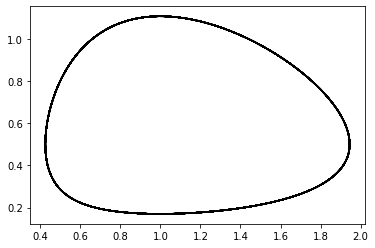

In [14]:
# Solving the Lotka-Volterra system
t1 = 0
t2 = 100
dt = 0.01
ts = np.arange(t1, t2, dt)
inicond = np.array([0.9, 1.1])
p_lv = np.array([2./3, -4./3, 1, -1])
p_lv_theory = [{'x': 2/3, 'x*y': -4/3}, {'x*y': 1, 'y': -1}]
sol_lv = solve(lotka_volterra, t1, t2, inicond, dt)(p_lv)
x, y = sol_lv[:, 0], sol_lv[:, 1]
plt.plot(x, y, c = 'k')

In [16]:
# Lotka-Volterra system parameter determination
p_lv_sindy = eq_coef_list(1e-5, theta_2d3p(clip(x), clip(y)), grads([x, y]), symb_theta_2d3p, 2, 0.5)
print('Theoretical parameter values:')
pp.pprint(p_lv_theory, width=1)
print('\nSINDy determined values:')
pp.pprint(p_lv_sindy, width=1)

Theoretical parameter values:
[{'x': 0.6666666666666666,
  'x*y': -1.3333333333333333},
 {'x*y': 1,
  'y': -1}]

SINDy determined values:
[{'x': 0.6665214606211742,
  'x*y': -1.3331525753234623},
 {'x*y': 0.9996760973539406,
  'y': -0.9995338198361428}]


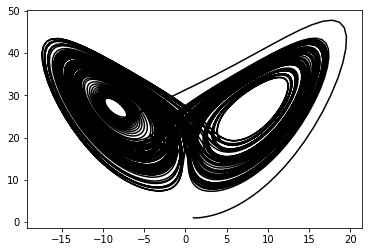

In [19]:
# Solving the Lorenz system
inicond = np.array([1, 1, 1])
p_lz = np.array([10, 28, 8./3.])
p_lz_theory = [{'x': -10, 'y': 10}, {'x': 28, 'y': -1, 'z*x': -1}, {'x*y': 1, 'z': -8/3}]
sol_lz = solve(lorenz, t1, t2, inicond, dt)(p_lz)
x, y, z = sol_lz[:, 0], sol_lz[:, 1], sol_lz[:, 2]
plt.plot(sol_lz[:, 0], sol_lz[:, 2], c = 'k', linestyle='-')

In [20]:
# Lorenz system parameter determination
p_lz_sindy = eq_coef_list(1e-5, theta_3d2p(clip(x), clip(y), clip(z)), grads([x, y, z]), symb_theta_3d2p, 3, 0.3)
print('Theoretical parameter values:')
pp.pprint(p_lz_theory, width=1)
print('\nSINDy determined values:')
pp.pprint(p_lz_sindy, width=1)

Theoretical parameter values:
[{'x': -10,
  'y': 10},
 {'x': 28,
  'y': -1,
  'z*x': -1},
 {'x*y': 1,
  'z': -2.6666666666666665}]

SINDy determined values:
[{'x': -9.974807842993599,
  'y': 9.97543354921183},
 {'x': 27.67249442288233,
  'y': -0.9248103558023243,
  'z*x': -0.9914360048637114},
 {'x*y': 0.9970540277057726,
  'z': -2.6589319700831733}]
